1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

In [1]:
import sys
!{sys.executable} -m pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org scikit-uplift==0.2.0

In [34]:
import sys
!{sys.executable} -m pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org catboost

  Created wheel for retrying: filename=retrying-1.3.3-cp37-none-any.whl size=11435 sha256=1ea52f28e30073f240bc00b7a313282ce23f2b3bb3331cb1359767ca89a372a4
  Stored in directory: C:\Users\6145~1\AppData\Local\pip\Cache\wheels\d7\a9\33\acc7b709e2a35caa7d4cae442f6fe6fbf2c43f80823d46460c
Successfully built retrying


In [60]:
import pandas as pd
import numpy as np

In [61]:
df = pd.read_csv('data.csv')
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [62]:
df = df.rename(columns={'conversion': 'target', 'offer': 'treatment'})

In [63]:
df.shape

(64000, 9)

In [64]:
len(df) - df.count()

recency          0
history          0
used_discount    0
used_bogo        0
zip_code         0
is_referral      0
channel          0
treatment        0
target           0
dtype: int64

In [65]:
df['treatment'].value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: treatment, dtype: int64

In [66]:
binary_to_numbers = {'Buy One Get One': 1, 'No Offer': 0, 'Discount' : 1}
df['treatment'] = df['treatment'].map(binary_to_numbers)
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0


In [67]:
from sklearn.model_selection import train_test_split

In [68]:
#разделим данные на train/test
indices = df.index 

indices_train, indices_test = train_test_split(df.index, test_size=0.3, random_state=123)

In [69]:
features = ['recency', 'history', 'used_discount', 'used_bogo', 'zip_code', 'is_referral', 'channel']

In [70]:
X_train = df[features].loc[indices_train, :]
y_train = df.loc[indices_train, 'target']
treat_train = df.loc[indices_train, 'treatment']

X_test = df[features].loc[indices_test, :]
y_test = df.loc[indices_test, 'target']
treat_test =  df.loc[indices_test, 'treatment']

X_train_full = df[features].loc[indices, :]
y_train_full = df.loc[:, 'target']
treat_train_full = df.loc[:, 'treatment']

In [71]:
models_results = {
    'approach': [],
    'uplift@10%': [], 
    'uplift@20%': []
}

In [72]:
#применим к фиче history стандартизацию, к 'zip_code', 'channel', 'recency' применим OHEencoding.

In [73]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['history']
cat_cols = ['zip_code', 'channel', 'recency']
base_cols = ['used_discount', 'used_bogo', 'is_referral']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [74]:
#объединим трансформеры с помощью featureunion
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers + cat_transformers + base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-0.47381568,  0.        ,  1.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 1.47059987,  0.        ,  0.        , ...,  0.        ,
         1.        ,  1.        ],
       [-0.22271852,  1.        ,  0.        , ...,  1.        ,
         0.        ,  1.        ],
       ...,
       [ 1.19649396,  1.        ,  0.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 0.38785603,  0.        ,  1.        , ...,  0.        ,
         1.        ,  0.        ],
       [-0.68708757,  1.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ]])

### S learner

In [75]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

from lightgbm import LGBMClassifier

uplift@10%: 0.0846
uplift@20%: 0.0782


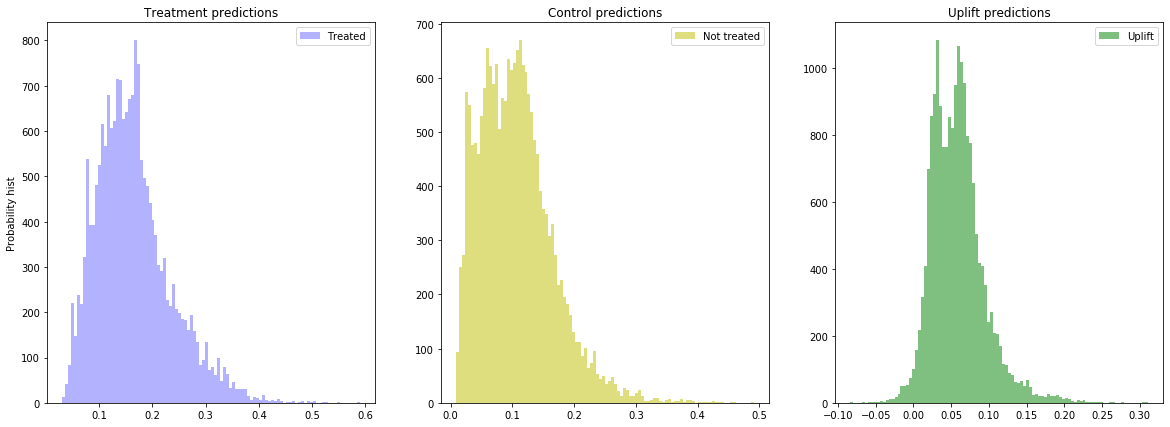

In [76]:
sm = SoloModel(LGBMClassifier(max_depth=5, random_state = 42, silent=True))


sm = sm.fit(feature_processing.fit_transform(X_train), y_train, treat_train)

uplift_sm = sm.predict(feature_processing.fit_transform(X_test))

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)
print(f'uplift@10%: {sm_score_10:.4f}')
print(f'uplift@20%: {sm_score_20:.4f}')

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

### Модель с трансформацией таргета

In [77]:
from sklift.models import ClassTransformation


ct = ClassTransformation(LGBMClassifier(max_depth=5, random_state = 42, silent=True))
ct = ct.fit(feature_processing.fit_transform(X_train), y_train, treat_train)

uplift_ct = ct.predict(feature_processing.fit_transform(X_test))

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)
print(f'uplift@10%: {ct_score_10:.4f}')
print(f'uplift@20%: {ct_score_20:.4f}')


models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)


C:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  """


uplift@10%: 0.0666
uplift@20%: 0.0731


### Две независимые модели

uplift@10%: 0.0549
uplift@20%: 0.0860


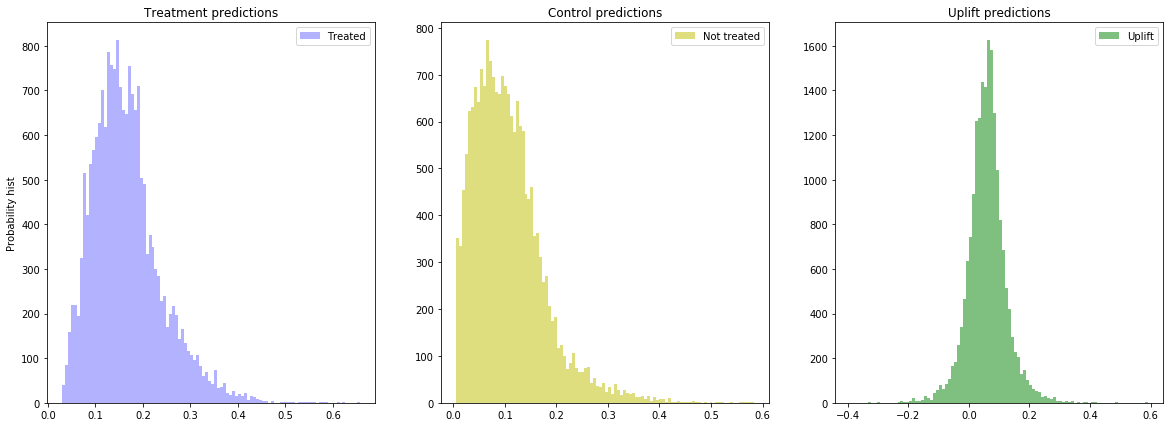

In [78]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=LGBMClassifier(max_depth=5, random_state = 42, silent=True), 
    estimator_ctrl=LGBMClassifier(max_depth=5, random_state = 42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    feature_processing.fit_transform(X_train), y_train, treat_train
)

uplift_tm = tm.predict(feature_processing.fit_transform(X_test))

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)

print(f'uplift@10%: {tm_score_10:.4f}')
print(f'uplift@20%: {tm_score_20:.4f}')

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [79]:
df_results = pd.DataFrame(models_results)
df_results 

,approach,uplift@10%,uplift@20%
0,SoloModel,0.084561,0.078208
1,ClassTransformation,0.066585,0.073134
2,TwoModels,0.054856,0.086020


In [ ]:
#Вывод: лучше всего себя показала модель SoloModel, хотя у модели TwoModels на топ 20 - хороший результат.